In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import skrf as rf           # install with "pip install scikit-rf"

## 1. Transmittance through a periodic grid

### a. Simulation

In [2]:
# Data

ax = 2.417  # [cm]
ay = 2.417  # [cm]
wx = 1.05   # [cm]
wy = 0.242  # [cm]
eta = 377   # [Ohm]

freq = loadmat("freq.mat")["freq"][0]                   # [GHz]
Z_mom_tot = loadmat("Z_mom_tot.mat")["Z_mom_tot"]       # [Ohm*cm²]


In [4]:
# Define axis
u = np.array([0,0,1])

E0 = 1
Einc = np.array([0,E0,0])               # E = E0 {y}
Hinc = (1/eta) * np.cross(u,Einc)       # H = (1/eta) E0 {-x}


T = np.zeros(len(freq))

Ampl = 1                    # Amplitude of rooftop vasis function
vol = 0.5*((2/9)*wx)*1*wy    # Volume of rooftop basis function      : V = (B*h)/2  * depth


w = np.ones(8)*vol*np.linalg.norm(Hinc) 

for i in range(len(freq)):

    
    Z = (2/(eta**2))*Z_mom_tot[i]
    x = np.linalg.solve(Z,w)

    E = (1/(ax*ay))*np.sum(x)*vol

    T[i] = np.linalg.norm(E)/np.linalg.norm(Einc)




Frequency of max transmittance : 11.3590 [GHz] | Tmax = 0.9614 [T] 


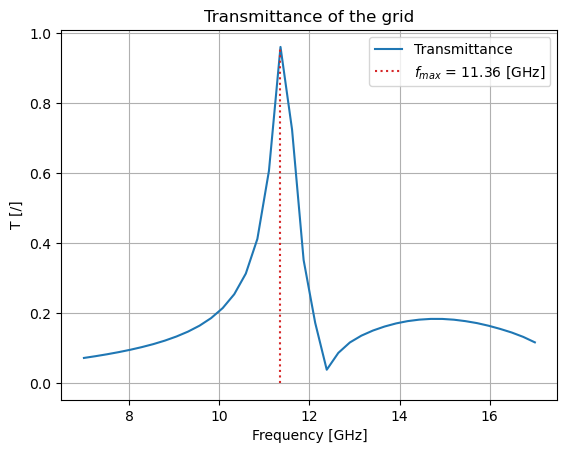

In [38]:
# Plot
fmax = freq[np.argmax(T)]
Tmax = T[np.argmax(T)]
print("Frequency of max transmittance : {:.4f} [GHz] | Tmax = {:.4f} [T] ".format(fmax,Tmax))
plt.plot(freq,T, label = "Transmittance")
plt.xlabel("Frequency [GHz]")
plt.ylabel("T [/]")
plt.title("Transmittance of the grid")
lgd = r"$f_{max}$ = " + "{:.2f} [GHz]".format(fmax)
plt.vlines(fmax,0,Tmax, color="tab:red", linestyles="dotted", label=lgd)
plt.legend()
plt.grid()
plt.show()

### b. Comparison with measurements

In [65]:
# How to read s2p file

def extract_s2p(filename):
    snp = rf.Network(filename)
    # Network.f is the frequencies at which the S-parameter is evaluated in the snp file
    f = snp.f
    # Network.s is a matrix with the shape [len(f),n,n]
    S_param = snp.s
    S11mes = S_param[:,0,0]; S12mes = S_param[:,0,1]; S21mes = S_param[:,1,0]; S22mes = S_param[:,1,1]
    return f, S11mes, S12mes, S21mes,S22mes

def nat2dB(S):
    ampl = 20*np.log10(np.abs(S))   # [dB]
    phase = np.angle(S)             # [deg]
    return ampl,phase

# f, _, _, S21, _ = extract_s2p("data/sansgrid.s2p")
# S21dB, S21deg = nat2dB(S21)
# plt.plot(f,S21dB)



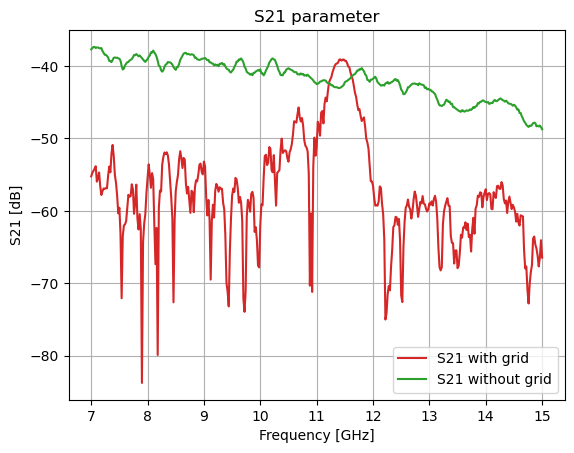

In [117]:
f_mes, _, _, S_grid, _ = extract_s2p("data/avecgrid.s2p")
_ , _, _, S_0 , _  =  extract_s2p("data/sansgrid.s2p")

S_grid_dB,_ = nat2dB(S_grid)
S_0_dB, _ = nat2dB(S_0)

plt.plot(f_mes*1e-9,S_grid_dB, color="tab:red", label = "S21 with grid")
plt.plot(f_mes*1e-9,S_0_dB, color="tab:green", label = "S21 without grid")
plt.xlabel("Frequency [GHz]")
plt.ylabel("S21 [dB]")
plt.title("S21 parameter")
plt.legend()
plt.grid()
plt.savefig("S21_grid.pdf")
plt.show()



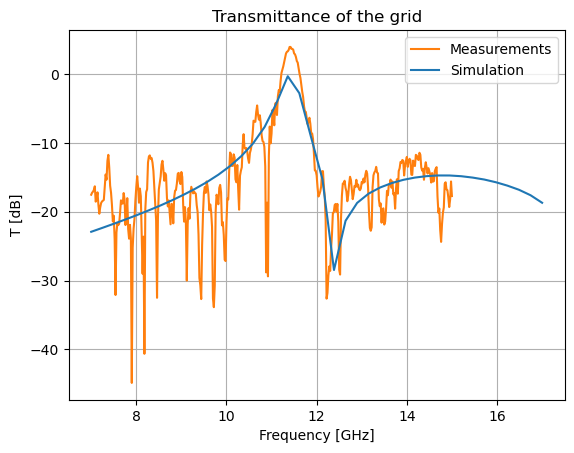

In [113]:
# Comparison

f_mes, _, _, S_grid, _ = extract_s2p("data/avecgrid.s2p")
_ , _, _, S_0 , _  =  extract_s2p("data/sansgrid.s2p")
T_mes = S_grid/S_0


T_simu_dB, _ = nat2dB(T)
T_mes_dB, _ = nat2dB(T_mes)

f_simu = freq*1e9

plt.plot(f_mes*1e-9,T_mes_dB, color="tab:orange", label = "Measurements")
plt.plot(f_simu*1e-9,T_simu_dB, color="tab:blue", label = "Simulation")
plt.xlabel("Frequency [GHz]")
plt.ylabel("T [dB]")
plt.title("Transmittance of the grid")

plt.legend()
plt.grid()
plt.savefig("TransmittanceGrid.pdf")
plt.show()



## 2. Arago spot

[-25. -20. -15. -10.  -7.  -5.   0.   5.   7.  10.  15.  20.  25.]
[ -0.14133924  -0.82362188  -4.76602791  -6.20680357 -12.1146343
 -13.49044757  -3.78266358 -11.22654301 -12.95361959  -8.32913769
  -5.25068745  -3.73410785  -0.3469149 ]


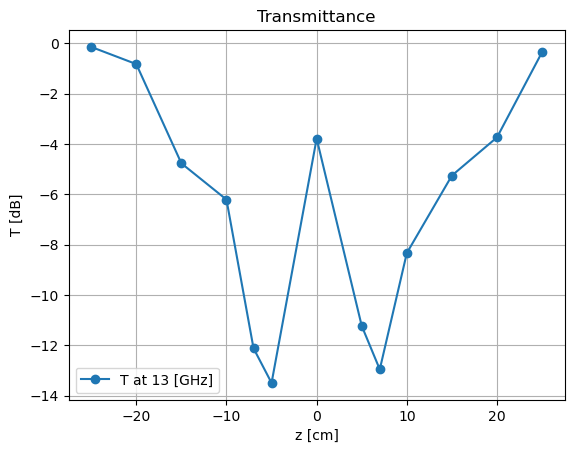

In [130]:
dist = np.array([5,7,10,15,20,25])
N = len(dist)
x = np.zeros((2*N+1))
# Transmittance
arago_left = np.zeros((N))  
arago_right = np.zeros((N))

fobs = 13*1e9  # [Hz] - Frequency of observation

f, _, _, S21ref, _ = extract_s2p("data/sansgrid.s2p")



# Left
for i,d in enumerate(np.flip(dist)):
    filename = "data/arago{}L.s2p".format(d)
    f, _, _, S21, _ = extract_s2p(filename)
    T_dB,_ = nat2dB(S21/S21ref)
    x[i] = -d

    idx = np.argmin(np.abs(f-fobs))
    arago_left[i] = T_dB[idx]


# Right
for i,d in enumerate((dist)):
    filename = "data/arago{}R.s2p".format(d)
    f, _, _, S21, _ = extract_s2p(filename)
    T_dB,_ = nat2dB(S21/S21ref)
    x[i+N+1] = d

    idx = np.argmin(np.abs(f-fobs))
    arago_right[i] = T_dB[idx]

f, _, _, S21, _ = extract_s2p("data/aragod0.s2p")

T_dB,_ = nat2dB(S21/S21ref)
idx = np.argmin(np.abs(f-fobs))
arago = np.concatenate((arago_left,[T_dB[idx]],arago_right))

print(x)
print(arago)

plt.title("Transmittance")
plt.plot(x,arago, "-o" , label = "T at {:.0f} [GHz]".format(fobs*1e-9))
plt.xlabel("z [cm]")
plt.ylabel("T [dB]")
plt.grid()
plt.legend()
plt.savefig("Arago.pdf")
plt.show()




